# Using ANN to predict Graduate Admissions Probability

The purpose of the project is to create and train a simple, custom Artificial Neural Network to perform regression and predict the probability of College Admissions for Masters Programs based on a number of input features. This project adapts code from a Kaggle notebook that created a Neural Network to perform a Binary Classification task which predicted Credit Card Customer Churn. For reference, this notebook can be found at the link below:
https://www.kaggle.com/code/mahimashukla12/binary-classification-churn-problem

## Imports

In [508]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Constants


In [509]:
FOLDER = "Datasets/"
ad = 'admission_data.csv'

## Data Imports

Explore file structure

In [510]:
ds_filepath = os.path.join(FOLDER,ad)
ds_filepath

'Datasets/admission_data.csv'

In [511]:
for dirname, _, filenames in os.walk(FOLDER):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Datasets/admission_data.csv


Import Data

In [512]:
data_grad=pd.read_csv(ds_filepath)

## Data Exploration

We can see the dataset has 8 columns, 4 integers and 4 float values and 500 rows

In [513]:
data_grad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


We can see that the standard deviation is showing us that these features are on different ranges so normalisation will be required

In [514]:
data_grad.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


In [515]:
data_grad.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


Check for duplicated rows

In [516]:
data_grad.duplicated().sum()

0

Check for rows with missing values

In [517]:
data_grad.isna().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [518]:
data_grad.Research.unique()

array([1, 0], dtype=int64)

In [519]:
data_grad.Research.value_counts()

Research
1    280
0    220
Name: count, dtype: int64

In [520]:
data_grad['University Rating'].value_counts()

University Rating
3    162
2    126
4    105
5     73
1     34
Name: count, dtype: int64

Check for data column distributions

This dataset is from Indian College Admissions for Masters programs
Exploring this data we have:
1. GRE Scores - Exam Scores
2. TOEFL Scores - This is a English Test
3. University Rating - This is on a discrete scale of 1 to 5
4. SOP - This is a rating of the Statement of Purpose on a discrete scale of 1 to 5
5. LOR - This is a rating of the Letter of Recommendation on a discrete scale of 1 to 5
6. CGPA - This is the Undergraduate GPA the candidate achieved on a discrete scale from 1 to 10
7. Research Experience - A Binary value of either 0 - None or 1 - Have Research Experience
8. Chance of Admit - The probability that the candidate will achieve admission

GRE Score, TOEFL Score, CGPA and Chance of Admit follow a normal distribution and Research is a binary value. The data distribution for research is fairly even so should not cause any overfitting issues. All other columns are on a scale of values, so their distribution should not cause problems.

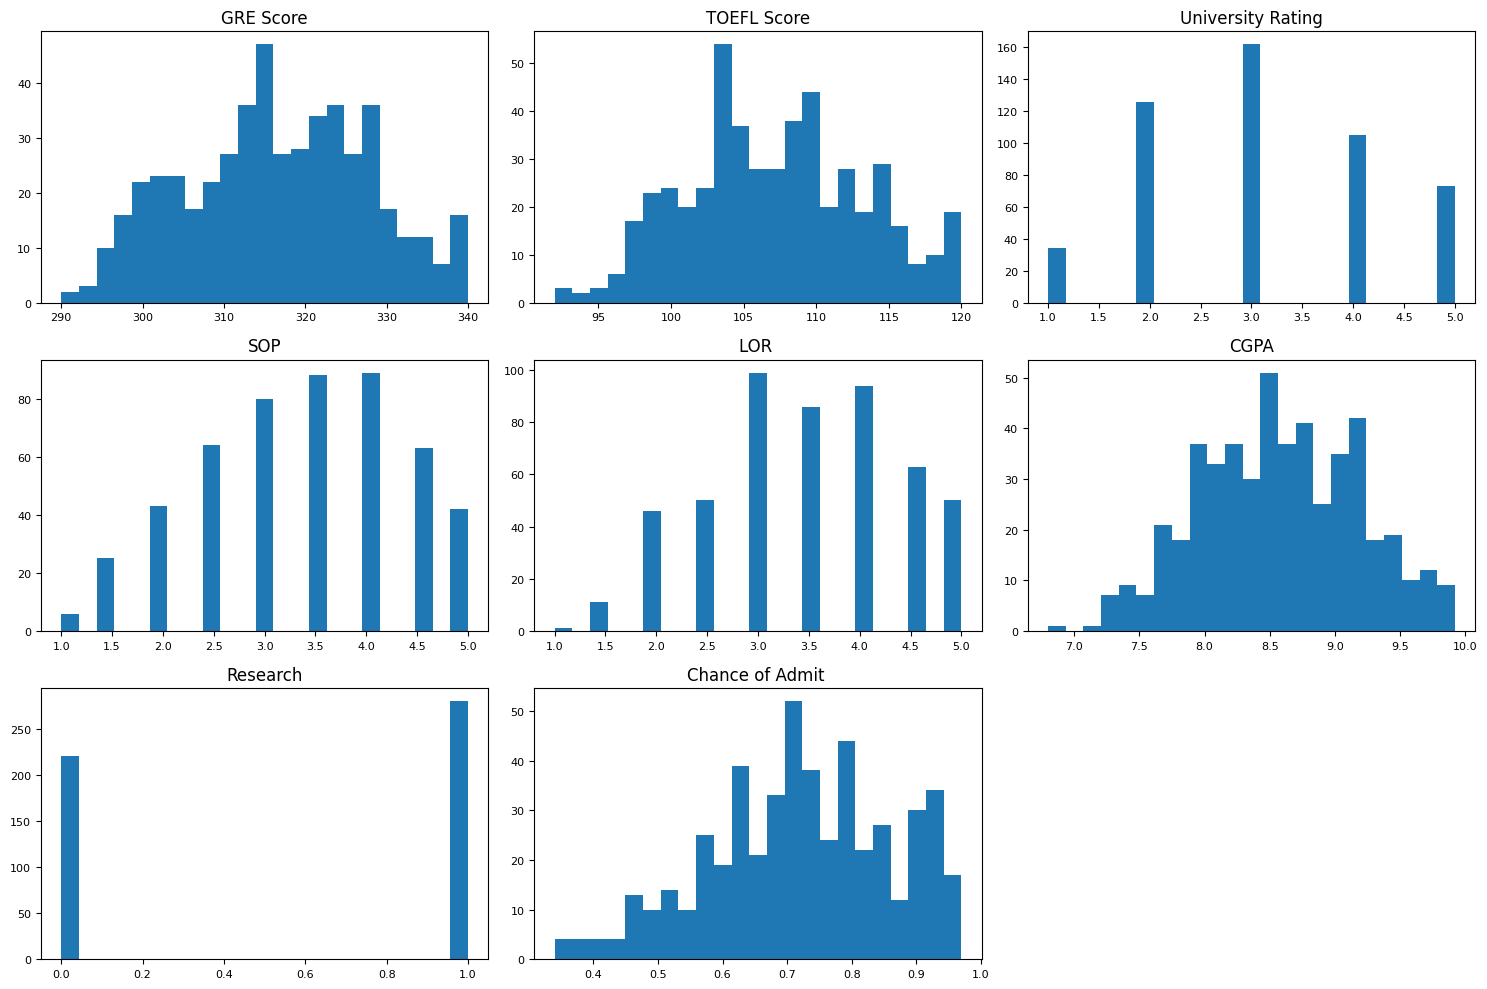

In [521]:
num_rows = 3
num_cols = 3
total_plots = num_rows * num_cols

plt.figure(figsize=(15, 10))

for i, col in enumerate(data_grad.columns):
    plt.subplot(num_rows, num_cols, i+1)
    plt.hist(data_grad[col], bins='sqrt')
    plt.title(col, fontsize=12)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Adjust layout
plt.tight_layout()

plt.show()

## Data Preprocessing

Seperate feature vector and dependent variable

In [522]:
X = data_grad.drop(['Chance of Admit '], axis=1)
X = X.values
y = data_grad['Chance of Admit ']
y = y.values

Seperate test and training data 80/20

In [523]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=108)

Use MinMaxScaler to normalise data columns

In [524]:
scale=MinMaxScaler()
X_train_norm=scale.fit_transform(X_train)
X_test_norm=scale.fit_transform(X_test)

Use StandardScalar to remove mean and divide by std to remove unit variance for comparison of which produces better results

In [525]:
scale=StandardScaler()
X_train_scale=scale.fit_transform(X_train)
X_test_scale=scale.fit_transform(X_test)

## Models

### Model #1
For Model 1, the model is extremely simple using only 3 neurons for hidden layer using Sigmoid for activation function with input dimensions of 7 for our 7 features. The activation function is changed to linear for Regression.

#### Model Creation

In [526]:
model1=Sequential()
model1.add(Dense(3,activation='sigmoid',input_dim=7))  #3 neurons for hidden layer
model1.add(Dense(1,activation='linear'))       #1 neuron for output since binary classification

In [527]:
model1.summary()

Model: "sequential_260"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_719 (Dense)           (None, 3)                 24        
                                                                 
 dense_720 (Dense)           (None, 1)                 4         
                                                                 
Total params: 28 (112.00 Byte)
Trainable params: 28 (112.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Change to mean_squared_error for Regression

In [528]:
#mean squared error is log loss
model1.compile(loss='mean_squared_error',optimizer='Adam')

In [529]:
hist_norm=model1.fit(X_train_norm,y_train,epochs=12)


Epoch 1/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0587
Epoch 2/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0494
Epoch 3/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0441
Epoch 4/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0417
Epoch 5/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0398
Epoch 6/12
13/13 [==============================] - 0s 5ms/step - loss: 0.0382
Epoch 7/12
13/13 [==============================] - 0s 3ms/step - loss: 0.0365
Epoch 8/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0349
Epoch 9/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0334
Epoch 10/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0319
Epoch 11/12
13/13 [==============================] - 0s 1ms/step - loss: 0.0305
Epoch 12/12
13/13 [==============================] - 0s 2ms/step - loss: 0.0292


#### Model Evaluation

In [530]:
hist_norm.history

{'loss': [0.058690719306468964,
  0.049445368349552155,
  0.04413928464055061,
  0.04173106700181961,
  0.039815761148929596,
  0.03817567601799965,
  0.03650860860943794,
  0.03491966798901558,
  0.03338935971260071,
  0.031911540776491165,
  0.030511027202010155,
  0.029202012345194817]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


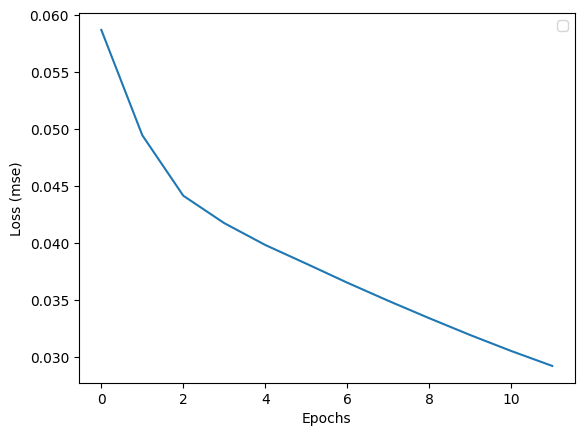

In [531]:
plt.plot(hist_norm.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.legend()
plt.show()

In [532]:
y_pred=model1.predict(X_test_norm)
y_pred

4/4 [==============================] - 0s 2ms/step


array([[0.69916993],
       [0.65172124],
       [0.72349256],
       [0.7528206 ],
       [0.7422735 ],
       [0.6509142 ],
       [0.7346523 ],
       [0.68967146],
       [0.77407503],
       [0.7012706 ],
       [0.67474395],
       [0.73538923],
       [0.76846296],
       [0.72710127],
       [0.74565244],
       [0.7184011 ],
       [0.66301   ],
       [0.70974773],
       [0.6846534 ],
       [0.6668768 ],
       [0.6749399 ],
       [0.67637515],
       [0.8068581 ],
       [0.6837519 ],
       [0.67783237],
       [0.6968049 ],
       [0.6518663 ],
       [0.6646354 ],
       [0.6813162 ],
       [0.6620512 ],
       [0.71614015],
       [0.79827857],
       [0.6056726 ],
       [0.70943266],
       [0.70969915],
       [0.6853927 ],
       [0.7027912 ],
       [0.67620397],
       [0.72751224],
       [0.71940047],
       [0.6786495 ],
       [0.7216916 ],
       [0.6443729 ],
       [0.6650617 ],
       [0.6835202 ],
       [0.69944465],
       [0.82008   ],
       [0.790

As this task is changing from binary classification to Regression, to evaluate the model mean_squared_error is used instead of accuracy to assess model performance.
With Model 1, the mse was .25. As all columns are normalised between 0 and 1, we can see that model performed poorly. This result is not surprising given its simplicity and short training duration.

In [533]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.02588071216019461


Next we'll Try with slightly more Epochs to see how model performs with more training

In [534]:
hist_norm=model1.fit(X_train_norm,y_train,epochs=20)

Epoch 1/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 2/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0268
Epoch 3/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 4/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 5/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0234
Epoch 6/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0216
Epoch 8/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0207
Epoch 9/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0199
Epoch 10/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0192
Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0185
Epoch 12/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0179
Epoch 13/20
13/13 [==============================

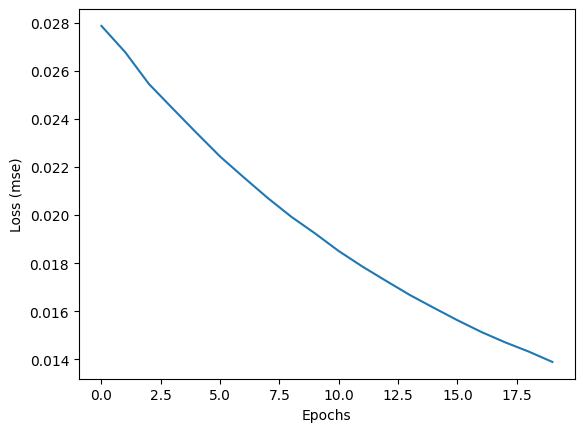

In [535]:
plt.plot(hist_norm.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss (mse)')
plt.show()

With an increased training duration model improved significantly to an mse of .0124 showing that an increased training duration does continue to improve performance. However, this result can probably be improved with a more complex model.

In [536]:
y_pred=model1.predict(X_test_norm)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

4/4 [==============================] - 0s 1ms/step
Mean Squared Error: 0.012458979999559744


Lets compare the results from MinMaxScaler vs StandardScaler
The mse obtained from the training data using StandardScalar was 0.006 which is a significantly better result. This may suggest that the unit variance between features is not significant in this task, however given the simplicity of this model, it is hard to say that these results are conclusive or if the model is underfitting to the data. The next step is to train these models multiple times and see if the results have large variance between runs.

In [537]:
hist_scale=model1.fit(X_train_scale,y_train,epochs=20)
y_pred=model1.predict(X_test_scale)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Epoch 1/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0183
Epoch 2/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0146
Epoch 3/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0134
Epoch 4/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0124
Epoch 5/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0115
Epoch 6/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0107
Epoch 7/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0100
Epoch 8/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0094
Epoch 9/20
13/13 [==============================] - 0s 1ms/step - loss: 0.0088
Epoch 10/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0084
Epoch 11/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0079
Epoch 12/20
13/13 [==============================] - 0s 2ms/step - loss: 0.0075
Epoch 13/20
13/13 [==============================

A plot of the difference in performance.

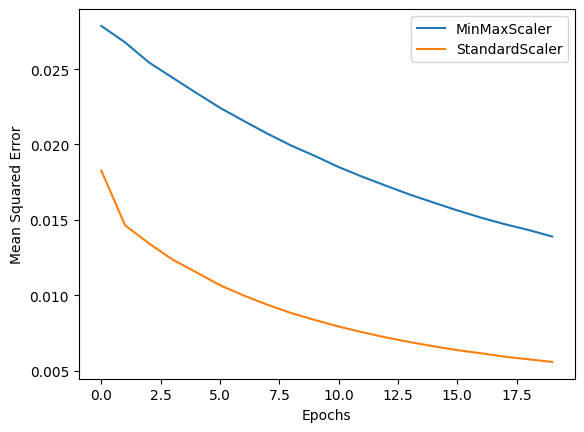

In [538]:
plt.plot(hist_norm.history['loss'], label='MinMaxScaler')
plt.plot(hist_scale.history['loss'], label='StandardScaler')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Given how simple this model is, we can expect that it may underfit the data and may fail to pick up complex patterns which may lead to high variability in performance even given the same training data. To test performance variability, we will try multiple runs to see if the average performance is consistent.

In [539]:
# Define function to create and train the model
def train_model(model, X_train, y_train, epochs):
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model, history

In [540]:
# Train the model multiple times with normalised training data
num_runs = 20
mse_scores = []

for i in range(num_runs):
    print(f"Training Run {i + 1}/{num_runs}")
    model, history = train_model(model1, X_train_norm, y_train, 20)
    y_pred = model.predict(X_test_norm)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for Run {i + 1}/{num_runs}: {mse}")
    mse_scores.append(mse)

# Calculate average
average_mse = np.mean(mse_scores)
print(f"Average MSE across {num_runs} runs: {average_mse}")

Training Run 1/20
4/4 [==============================] - 0s 3ms/step
MSE for Run 1/20: 0.0064212470555499775
Training Run 2/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 2/20: 0.004698716571223472
Training Run 3/20
4/4 [==============================] - 0s 1000us/step
MSE for Run 3/20: 0.004214152477883286
Training Run 4/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 4/20: 0.003989176081328077
Training Run 5/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 5/20: 0.004138840309229259
Training Run 6/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 6/20: 0.00417688691817964
Training Run 7/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 7/20: 0.004304064484456992
Training Run 8/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 8/20: 0.004249952422026685
Training Run 9/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 9/20: 0.004482623710651187
Training Run 10/20
4/4 [=

In [541]:
# Train the model multiple times with scaled training data
num_runs = 20
mse_scores = []

for i in range(num_runs):
    print(f"Training Run {i + 1}/{num_runs}")
    model, history = train_model(model1, X_train_scale, y_train, 20)
    y_pred = model.predict(X_test_scale)
    mse = mean_squared_error(y_test, y_pred)
    print(f"MSE for Run {i + 1}/{num_runs}: {mse}")
    mse_scores.append(mse)

# Calculate average
average_mse = np.mean(mse_scores)
print(f"Average MSE across {num_runs} runs: {average_mse}")

Training Run 1/20
4/4 [==============================] - 0s 2ms/step
MSE for Run 1/20: 0.02700614005423804
Training Run 2/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 2/20: 0.009083046403800159
Training Run 3/20
4/4 [==============================] - 0s 999us/step
MSE for Run 3/20: 0.005679618799480594
Training Run 4/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 4/20: 0.004916129950955357
Training Run 5/20
4/4 [==============================] - 0s 999us/step
MSE for Run 5/20: 0.004440135313867077
Training Run 6/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 6/20: 0.004632907130160108
Training Run 7/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 7/20: 0.004675236978774156
Training Run 8/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 8/20: 0.004537904632906572
Training Run 9/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 9/20: 0.0045418624395777854
Training Run 10/20
4/4 [

As we can see from the above tests, there is large variances between runs which I suspect is a sign that the model is underfitting to the data.

### Model 2
For Model 2, the model is much more complex with the number of neurons increased to 11 and an additional hidden layer added with 11 neurons. Both layers now use Relu for their activation function in an attempt to increase the models ability to model more complex patterns in the dataset. This model also splits off a validation set from the training data so we can also evaluate its performance on unseen data as the model is trained. The training time will also be increased to give the model more time to learn the patterns in the data. 

#### Model Creation

In [542]:
model2=Sequential()
model2.add(Dense(11,activation='relu',input_dim=7))  
model2.add(Dense(11,activation='relu'))       
model2.add(Dense(1,activation='linear'))

model2.summary()

Model: "sequential_261"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_721 (Dense)           (None, 11)                88        
                                                                 
 dense_722 (Dense)           (None, 11)                132       
                                                                 
 dense_723 (Dense)           (None, 1)                 12        
                                                                 
Total params: 232 (928.00 Byte)
Trainable params: 232 (928.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [557]:
model2.compile(loss='mean_squared_error',optimizer='Adam', metrics=['mse'])
hist_norm=model2.fit(X_train_norm,y_train,epochs=40,validation_split=0.2)

Epoch 1/40
10/10 [==============================] - 1s 18ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 2/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0066 - val_mse: 0.0066
Epoch 3/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 4/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0049 - val_mse: 0.0049
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0050 - mse: 0.0050 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 6/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0047 - mse: 0.0047 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 7/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0045 - mse: 0.0045 - val_loss: 0.0044 - val_mse: 0.0044
Epoch 8/40
10/10 [==============================] - 0s 8ms/step - loss: 0.0043 - mse: 0.0

#### Model Evaluation

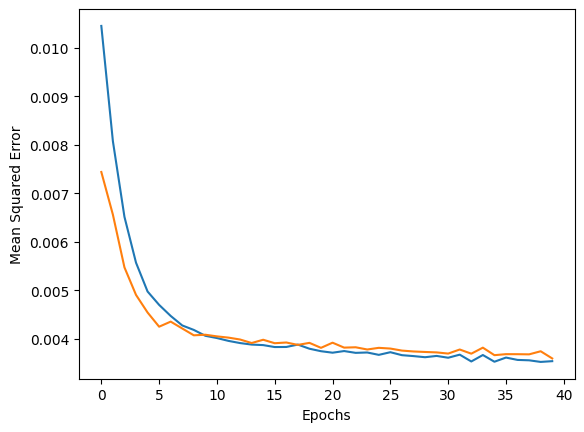

In [558]:
plt.plot(hist_norm.history['mse'])
plt.plot(hist_norm.history['val_mse'])
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

Model 2 achieved much better performance at .0046 mse. This is not bad performance and shows that the more complex model using relu activation has improved its ability to learn the patterns of the training data. The fact that the validation mse is the same as the training loss also shows that the model is generalising well to unseen data and we can be more confidant that it is not underfitting like model 1. 

In [559]:
y_pred=model2.predict(X_test_norm)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

4/4 [==============================] - 0s 1ms/step
Mean Squared Error: 0.00463795998939986


The model training with the StandardScalar training data performed marginally worse with a mse of .0070 which does indicate that the unit variance is significant in this task.

In [560]:
model2.compile(loss='mean_squared_error',optimizer='Adam', metrics=['mse'])
hist_scale=model2.fit(X_train_scale,y_train,epochs=40,validation_split=0.2)
y_pred=model2.predict(X_test_scale)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Epoch 1/40


10/10 [==============================] - 1s 19ms/step - loss: 0.0491 - mse: 0.0491 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 2/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0160 - mse: 0.0160 - val_loss: 0.0103 - val_mse: 0.0103
Epoch 3/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0101 - mse: 0.0101 - val_loss: 0.0087 - val_mse: 0.0087
Epoch 4/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0065 - val_mse: 0.0065
Epoch 5/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 6/40
10/10 [==============================] - 0s 6ms/step - loss: 0.0046 - mse: 0.0046 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 7/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 8/40
10/10 [==============================] - 0s 5ms/step - loss: 0.0036 - mse: 0.0036 - val_l

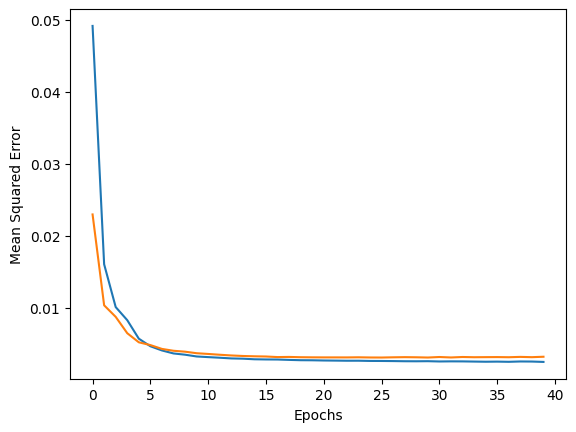

In [561]:
plt.plot(hist_scale.history['mse'])
plt.plot(hist_scale.history['val_mse'])
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

In [563]:
## Turn this code into function
def showResults(num_runs, model, X_train, y_train, X_test, y_test):
# Train the model multiple times with scaled training data
    mse_scores = []

    for i in range(num_runs):
        print(f"Training Run {i + 1}/{num_runs}")
        model, history = train_model(model, X_train, y_train, 20)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"MSE for Run {i + 1}/{num_runs}: {mse}")
        mse_scores.append(mse)

    # Calculate average
    average_mse = np.mean(mse_scores)
    print(f"Average MSE across {num_runs} runs: {average_mse}")

Training results here also show less variability with the average being close to the results obtained at 0.0049, another indication that the model is no longer underfitting as much to the data.

In [564]:
showResults(20, model2, X_train_norm, y_train, X_test_norm, y_test)

Training Run 1/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 1/20: 0.004202701332647969
Training Run 2/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 2/20: 0.004395227305955965
Training Run 3/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 3/20: 0.0049468845672999626
Training Run 4/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 4/20: 0.004509894518341451
Training Run 5/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 5/20: 0.0052128602071577455
Training Run 6/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 6/20: 0.004818202834787651
Training Run 7/20
4/4 [==============================] - 0s 1000us/step
MSE for Run 7/20: 0.0051959097886942794
Training Run 8/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 8/20: 0.005065147365788482
Training Run 9/20
4/4 [==============================] - 0s 1ms/step
MSE for Run 9/20: 0.005495802888267664
Training Run 10/20
4/4

### Model 3
For Model 3, we will take our previous model and try and tune some hyperparameters using GridSearchCV is an attempt to improve results.
Credit to https://www.kaggle.com/code/aaryandhore/neural-network-gridsearchcv-explanations for the code for using GridSearchCV with neural networks

In [571]:
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define Keras model creation function
def create_model():
    model = Sequential()
    model.add(Dense(11,activation='relu',input_dim=7))  
    model.add(Dense(11,activation='relu'))       
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mean_squared_error')
    return model

# Create KerasRegressor wrapper
keras_regressor = KerasRegressor(build_fn=create_model)

# Define parameter grid
param_grid = {'batch_size': [16, 32],
              'epochs': [50, 100],
              'optimizer': ['Adam', 'RMSprop', 'SGD']}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=keras_regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_result = grid_search.fit(X_train, y_train)

# Print best parameters and best MSE
print("Best Parameters: ", grid_result.best_params_)
print("Best MSE: ", grid_result.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Epoch 1/50


C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 899.1092
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 14.5150
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 0.0924
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 0.0993
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 1.5472
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 1.9119
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 2.0073
Epoch 8/50
17/17 [==============================] - 0s 2ms/step - loss: 1.9036
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 1.8266
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 1.8650
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 2.0885
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 1.7982
Epoch 13/50
17/17 [==============================] - 0s 1

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 2904.2722
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 1028.0508
Epoch 3/50
17/17 [==============================] - 0s 2ms/step - loss: 319.9035
Epoch 4/50
17/17 [==============================] - 0s 2ms/step - loss: 55.7465
Epoch 5/50
17/17 [==============================] - 0s 2ms/step - loss: 2.4023
Epoch 6/50
17/17 [==============================] - 0s 2ms/step - loss: 0.2284
Epoch 7/50
17/17 [==============================] - 0s 2ms/step - loss: 0.2275
Epoch 8/50
17/17 [==============================] - 0s 2ms/step - loss: 0.5515
Epoch 9/50
17/17 [==============================] - 0s 2ms/step - loss: 0.4672
Epoch 10/50
17/17 [==============================] - 0s 2ms/step - loss: 0.5789
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4878
Epoch 12/50
17/17 [==============================] - 0s 2ms/step - loss: 0.4892
Epoch 13/50
17/17 [==============================] 

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 1s 1ms/step - loss: 2410.8755
Epoch 2/50
17/17 [==============================] - 0s 2ms/step - loss: 435.7171
Epoch 3/50
17/17 [==============================] - 0s 2ms/step - loss: 31.0195
Epoch 4/50
17/17 [==============================] - 0s 2ms/step - loss: 2.4263
Epoch 5/50
17/17 [==============================] - 0s 2ms/step - loss: 2.4375
Epoch 6/50
17/17 [==============================] - 0s 2ms/step - loss: 2.7676
Epoch 7/50
17/17 [==============================] - 0s 4ms/step - loss: 2.4513
Epoch 8/50
17/17 [==============================] - 0s 4ms/step - loss: 3.1077
Epoch 9/50
17/17 [==============================] - 0s 3ms/step - loss: 2.9959
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 3.0468
Epoch 11/50
17/17 [==============================] - 0s 2ms/step - loss: 2.2713
Epoch 12/50
17/17 [==============================] - 0s 2ms/step - loss: 2.6692
Epoch 13/50
17/17 [==============================] - 0

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 143.3877
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2330
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2057
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 1.3410
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 1.2450
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 1.2385
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 1.0843
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 1.8014
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 1.1892
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 1.4499
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 1.2093
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 1.2517
Epoch 13/50
17/17 [==============================] - 0s 1m

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 1356.6306
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 227.2454
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 18.4207
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3136
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 0.0444
Epoch 6/50
17/17 [==============================] - 0s 2ms/step - loss: 0.0448
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2995
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2814
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3346
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 0.2836
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3918
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3506
Epoch 13/50
17/17 [==============================] - 0

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 0.9889
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4257
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 0.5385
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4847
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4961
Epoch 6/50
17/17 [==============================] - 0s 4ms/step - loss: 0.4527
Epoch 7/50
17/17 [==============================] - 0s 2ms/step - loss: 0.4899
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4520
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4751
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 0.4711
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 0.3028
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 0.5119
Epoch 13/50
17/17 [==============================] - 0s 1ms/

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 8954.5488
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 6159.0640
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 4321.3569
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 2925.6868
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 1875.7050
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 1110.8708
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 527.4646
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 172.7210
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 28.3167
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 1.7341
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 0.8555
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 0.8541
Epoch 13/50
17/17 [==================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 7351.2163
Epoch 2/50
17/17 [==============================] - 0s 1ms/step - loss: 2790.6501
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 718.3488
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 81.5328
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 1.1684
Epoch 6/50
17/17 [==============================] - 0s 2ms/step - loss: 0.1427
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 0.1596
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 0.9474
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 1.3044
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 1.1299
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 1.0832
Epoch 12/50
17/17 [==============================] - 0s 2ms/step - loss: 1.0575
Epoch 13/50
17/17 [==============================] 

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 2701.5537
Epoch 2/50
17/17 [==============================] - 0s 2ms/step - loss: 560.6385
Epoch 3/50
17/17 [==============================] - 0s 1ms/step - loss: 53.0945
Epoch 4/50
17/17 [==============================] - 0s 1ms/step - loss: 2.3632
Epoch 5/50
17/17 [==============================] - 0s 1ms/step - loss: 1.9476
Epoch 6/50
17/17 [==============================] - 0s 1ms/step - loss: 1.9862
Epoch 7/50
17/17 [==============================] - 0s 1ms/step - loss: 2.6175
Epoch 8/50
17/17 [==============================] - 0s 1ms/step - loss: 2.4526
Epoch 9/50
17/17 [==============================] - 0s 1ms/step - loss: 2.7116
Epoch 10/50
17/17 [==============================] - 0s 1ms/step - loss: 2.1175
Epoch 11/50
17/17 [==============================] - 0s 1ms/step - loss: 2.2242
Epoch 12/50
17/17 [==============================] - 0s 1ms/step - loss: 2.2722
Epoch 13/50
17/17 [==============================] - 0

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 28918.8809
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 14436.4707
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 6896.6284
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 2522.4219
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 556.5855
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 57.2266
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 3.2657
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7071
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 1.8831
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 2.2187
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 1.9548
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 2.8858
Epoch 13/100
17/17 [============

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 216.7660
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7595
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0543
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0960
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.9865
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.9022
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8479
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8788
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8612
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8695
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8006
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7409
Epoch 13/100
17/17 [===========================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 1809.4077
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 532.4838
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 125.9649
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 23.1283
Epoch 5/100
17/17 [==============================] - 0s 2ms/step - loss: 1.1858
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.0638
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 0.0570
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1301
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2720
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1780
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2270
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2246
Epoch 13/100
17/17 [=====================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 549.0551
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 39.3602
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.4676
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1559
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1708
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6280
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5962
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5761
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6681
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.4750
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5759
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5308
Epoch 13/100
17/17 [==========================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 9.9106
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 1.2148
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7177
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 1.5947
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 1.3833
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6666
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 1.4719
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6135
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 1.5864
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 1.3198
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 1.4338
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6374
Epoch 13/100
17/17 [=============================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 8.4596
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 5.6709
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 5.2441
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 1.9661
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7586
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 1.5703
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 1.8288
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7024
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 1.3873
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6498
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7965
Epoch 12/100
17/17 [==============================] - 0s 2ms/step - loss: 1.3835
Epoch 13/100
17/17 [=============================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 117.5048
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 4.1476
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 3.1868
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 1.7339
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 1.9282
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 2.0280
Epoch 7/100
17/17 [==============================] - 0s 2ms/step - loss: 2.0641
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 1.8874
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 1.8631
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 2.0826
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6761
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 1.6046
Epoch 13/100
17/17 [===========================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 1s 1ms/step - loss: 8.5953
Epoch 2/100
17/17 [==============================] - 0s 2ms/step - loss: 0.1507
Epoch 3/100
17/17 [==============================] - 0s 2ms/step - loss: 0.6981
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5715
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 1.0006
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5997
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7040
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6766
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8060
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7158
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7505
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6427
Epoch 13/100
17/17 [=============================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


17/17 [==============================] - 0s 1ms/step - loss: 12511.9570
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 6315.4380
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 3046.8604
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 1018.0028
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 170.1898
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 6.6781
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1341
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1253
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.8051
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7974
Epoch 11/100
17/17 [==============================] - 0s 1ms/step - loss: 0.7302
Epoch 12/100
17/17 [==============================] - 0s 1ms/step - loss: 0.6991
Epoch 13/100
17/17 [==============

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 846.4050
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 188.3266
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 33.5730
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 2.9290
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4500
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4075
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4027
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4108
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4301
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 0.9392
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 0.9456
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 1.0405
Epoch 13/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7758
E

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 64.8688
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1497
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1762
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 1.3310
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 3.9173
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 4.0219
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 2.6656
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 3.6307
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 3.2790
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 3.1994
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 4.1693
Epoch 12/50
9/9 [==============================] - 0s 1ms/step - loss: 2.8524
Epoch 13/50
9/9 [==============================] - 0s 1ms/step - loss: 3.0684
Epoch

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 2405.4695
Epoch 2/50
9/9 [==============================] - 0s 1ms/step - loss: 816.6884
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 252.2348
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 50.3700
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 4.3716
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1970
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1218
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1210
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 0.1249
Epoch 10/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1580
Epoch 11/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4166
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7859
Epoch 13/50
9/9 [==============================] - 0s 2ms/step - loss: 1.248

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 920.5137
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 291.0190
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 83.4239
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 15.2771
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4673
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3856
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.3601
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3513
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 0.3414
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3735
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 0.9191
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 0.4442
Epoch 13/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7046


C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 1379.4363
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 394.2053
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 101.2057
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 15.7733
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 2.0966
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4045
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 1.3708
Epoch 8/50
9/9 [==============================] - 0s 1ms/step - loss: 1.3498
Epoch 9/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4102
Epoch 10/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4110
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 2.7134
Epoch 12/50
9/9 [==============================] - 0s 1ms/step - loss: 1.4664
Epoch 13/50
9/9 [==============================] - 0s 1ms/step - loss: 2.198

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 821.7330
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 114.7943
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 10.0431
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 0.4918
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2642
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2673
Epoch 7/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2661
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 0.3423
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2655
Epoch 10/50
9/9 [==============================] - 0s 1ms/step - loss: 2.3934
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 1.0998
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 0.8540
Epoch 13/50
9/9 [==============================] - 0s 1ms/step - loss: 1.3518
E

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 3ms/step - loss: 6.8087
Epoch 2/50
9/9 [==============================] - 0s 4ms/step - loss: 1.0526
Epoch 3/50
9/9 [==============================] - 0s 3ms/step - loss: 1.1377
Epoch 4/50
9/9 [==============================] - 0s 4ms/step - loss: 2.2281
Epoch 5/50
9/9 [==============================] - 0s 3ms/step - loss: 2.2513
Epoch 6/50
9/9 [==============================] - 0s 3ms/step - loss: 1.3050
Epoch 7/50
9/9 [==============================] - 0s 3ms/step - loss: 1.3827
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 1.4175
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 1.6449
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 1.6485
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 1.4768
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 1.3448
Epoch 13/50
9/9 [==============================] - 0s 2ms/step - loss: 1.2866
Epoch 

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 1680.2098
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 288.3475
Epoch 3/50
9/9 [==============================] - 0s 1ms/step - loss: 32.9107
Epoch 4/50
9/9 [==============================] - 0s 1ms/step - loss: 1.3815
Epoch 5/50
9/9 [==============================] - 0s 1ms/step - loss: 0.2121
Epoch 6/50
9/9 [==============================] - 0s 1ms/step - loss: 0.1991
Epoch 7/50
9/9 [==============================] - 0s 5ms/step - loss: 0.2134
Epoch 8/50
9/9 [==============================] - 0s 3ms/step - loss: 0.2828
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 1.6865
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 1.4546
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 1.8349
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 2.2983
Epoch 13/50
9/9 [==============================] - 0s 3ms/step - loss: 1.3855


C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 323.9369
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 12.5277
Epoch 3/50
9/9 [==============================] - 0s 4ms/step - loss: 0.4038
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2561
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2539
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2456
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.2439
Epoch 8/50
9/9 [==============================] - 0s 2ms/step - loss: 1.6489
Epoch 9/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7290
Epoch 10/50
9/9 [==============================] - 0s 2ms/step - loss: 1.2326
Epoch 11/50
9/9 [==============================] - 0s 2ms/step - loss: 1.5489
Epoch 12/50
9/9 [==============================] - 0s 2ms/step - loss: 0.7598
Epoch 13/50
9/9 [==============================] - 0s 2ms/step - loss: 1.3849
Epo

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 10990.8369
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 6735.1748
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 4387.6270
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 2934.9426
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1994.0381
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1267.3245
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 737.0678
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 376.1320
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 154.8650
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 44.2600
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 7.0122
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5728
Epoch 13/100
9/9 [=============================

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 2ms/step - loss: 0.2013
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0402
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0449
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 0.0513
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0434
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0513
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0370
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 0.0519
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0547
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0428
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0603
Epoch 13/100
9/9 [==============================] - 0s 2ms/step - loss: 0

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 1s 2ms/step - loss: 2442.8674
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 551.0461
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 87.5202
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 5.7297
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2499
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1880
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1904
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1960
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2490
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 3.2258
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 1.2460
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 2.2353
Epoch 13/100
9/9 [==============================] - 0s 2ms/step - l

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 5293.3799
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 2128.8259
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 824.4326
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 238.3770
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 39.5186
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 2.4913
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0654
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0390
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0393
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0409
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0484
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 2.5702
Epoch 13/100
9/9 [==============================] - 0s 2ms/ste

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 2407.6575
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 594.6391
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 136.1795
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 17.8707
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.8161
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0375
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0322
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0326
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0317
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5317
Epoch 11/100
9/9 [==============================] - 0s 4ms/step - loss: 1.5004
Epoch 12/100
9/9 [==============================] - 0s 3ms/step - loss: 1.4518
Epoch 13/100
9/9 [==============================] - 0s 3ms/step -

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 22.2545
Epoch 2/100
9/9 [==============================] - 0s 1ms/step - loss: 0.1065
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0562
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0562
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0772
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 0.3864
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1448
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.3298
Epoch 9/100
9/9 [==============================] - 0s 1ms/step - loss: 0.2775
Epoch 10/100
9/9 [==============================] - 0s 1ms/step - loss: 0.1809
Epoch 11/100
9/9 [==============================] - 0s 1ms/step - loss: 0.3670
Epoch 12/100
9/9 [==============================] - 0s 1ms/step - loss: 0.2471
Epoch 13/100
9/9 [==============================] - 0s 1ms/step - loss: 

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 369.7691
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 22.0808
Epoch 3/100
9/9 [==============================] - 0s 1ms/step - loss: 0.9289
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5132
Epoch 5/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5202
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5839
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 0.6624
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.4933
Epoch 9/100
9/9 [==============================] - 0s 1ms/step - loss: 2.3029
Epoch 10/100
9/9 [==============================] - 0s 1ms/step - loss: 0.4831
Epoch 11/100
9/9 [==============================] - 0s 1ms/step - loss: 1.5492
Epoch 12/100
9/9 [==============================] - 0s 1ms/step - loss: 0.9062
Epoch 13/100
9/9 [==============================] - 0s 1ms/step - loss

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 1008.3124
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 266.2238
Epoch 3/100
9/9 [==============================] - 0s 1ms/step - loss: 61.2361
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 8.0191
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5497
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2232
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 0.2214
Epoch 8/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2248
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.2359
Epoch 10/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5543
Epoch 11/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6361
Epoch 12/100
9/9 [==============================] - 0s 2ms/step - loss: 0.6675
Epoch 13/100
9/9 [==============================] - 0s 2ms/step - l

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


9/9 [==============================] - 0s 1ms/step - loss: 1449.7548
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 368.2720
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 76.0932
Epoch 4/100
9/9 [==============================] - 0s 1ms/step - loss: 10.3986
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 0.5921
Epoch 6/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0474
Epoch 7/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0430
Epoch 8/100
9/9 [==============================] - 0s 1ms/step - loss: 0.0422
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 0.0423
Epoch 10/100
9/9 [==============================] - 0s 2ms/step - loss: 0.1051
Epoch 11/100
9/9 [==============================] - 0s 1ms/step - loss: 1.1255
Epoch 12/100
9/9 [==============================] - 0s 1ms/step - loss: 0.5077
Epoch 13/100
9/9 [==============================] - 0s 2ms/step - 

C:\Users\SKy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


25/25 [==============================] - 0s 1ms/step - loss: 55.9810
Epoch 2/100
25/25 [==============================] - 0s 1ms/step - loss: 3.1270
Epoch 3/100
25/25 [==============================] - 0s 1ms/step - loss: 3.8162
Epoch 4/100
25/25 [==============================] - 0s 1ms/step - loss: 5.7673
Epoch 5/100
25/25 [==============================] - 0s 1ms/step - loss: 4.0798
Epoch 6/100
25/25 [==============================] - 0s 1ms/step - loss: 5.3306
Epoch 7/100
25/25 [==============================] - 0s 1ms/step - loss: 4.4885
Epoch 8/100
25/25 [==============================] - 0s 1ms/step - loss: 4.7972
Epoch 9/100
25/25 [==============================] - 0s 1ms/step - loss: 4.8723
Epoch 10/100
25/25 [==============================] - 0s 1ms/step - loss: 4.6932
Epoch 11/100
25/25 [==============================] - 0s 1ms/step - loss: 4.1889
Epoch 12/100
25/25 [==============================] - 0s 1ms/step - loss: 4.6027
Epoch 13/100
25/25 [============================

In [572]:
model3 = Sequential()
model3.add(Dense(11,activation='relu',input_dim=7))  
model3.add(Dense(11,activation='relu'))       
model3.add(Dense(1,activation='linear'))
model3.compile(loss='mean_squared_error',optimizer='RMSprop')
hist=model3.fit(X_train_norm,y_train,epochs=100,batch_size=16,validation_split=0.2)

Epoch 1/100
20/20 [==============================] - 1s 8ms/step - loss: 0.8441 - val_loss: 0.3508
Epoch 2/100
20/20 [==============================] - 0s 3ms/step - loss: 0.2026 - val_loss: 0.0543
Epoch 3/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0455 - val_loss: 0.0228
Epoch 4/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0297 - val_loss: 0.0189
Epoch 5/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0234 - val_loss: 0.0144
Epoch 6/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.0113
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0138 - val_loss: 0.0091
Epoch 8/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0078
Epoch 9/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0088 - val_loss: 0.0066
Epoch 10/100
20/20 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0058
Epoch 11/

For this result, the results obtained for the training and validation data are better than for model 2, however it performed slightly worse on the test data. However, the differences here are very small indicating that the results obtained through additional epochs are not increasing and show that the model has reached its maximum performance potential. Significant further gains with this model do not seem possible with only marginal changes to the results obtained. To achieve further performance, I think that additional complexity would have to be added to the model to learn more subtle difference in the training data.

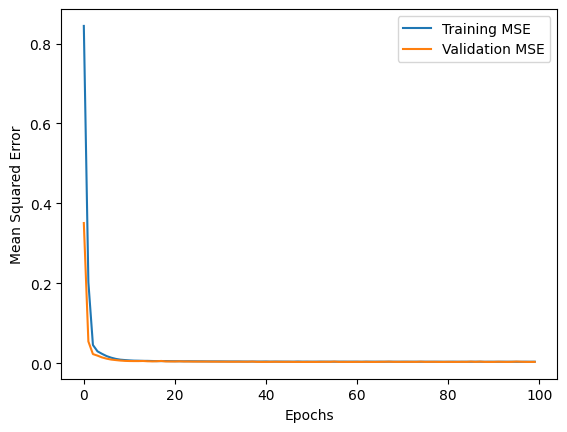

In [583]:
plt.plot(hist.history['loss'], label='Training MSE')
plt.plot(hist.history['val_loss'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [579]:
y_pred=model3.predict(X_test_norm)
y_pred
mse = mean_squared_error(y_test, y_pred)
mse

4/4 [==============================] - 0s 2ms/step


0.0052884238196778685